# Predicción de bancarrota empresarial

En este proyecto, se utilizan datos reales para predecir el si una empresa se declarará en bancarrota en el año siguiente a la observación de su información financiera. Para cada empresa, se tienen en total 63 razones financieras calculadas y la muestra corresponde a compañías en China durante los años de 1999 a 2009 que aparecen en el Shanghai Stock Exchange.

A continuación, se presentan las etapas para realizar un modelamiento predictivo de bancarrota empresarial mediante el uso de redes neuronales MLP. El informe se divide en las siguientes secciones:
1. Exploración de los datos (10 puntos)
2. Preparación de los datos (10 puntos)
3. Análisis preliminar de selección de modelos (20 puntos)
4. Desarrollo y calibración de modelos (40 puntos)
5. Visualización de resultados (20 puntos)

### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configuraciones estéticas
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


***
## 1. Exploración de los datos

La sección de Exploración de Datos tiene como objetivo entender la estructura, características y calidad del conjunto de datos. Aquí se realiza un análisis descriptivo inicial que incluye la revisión de las dimensiones del dataset, tipos de variables, valores faltantes, estadísticas descripotivas y patrones relevantes. 

Esta etapa es fundamental para identificar posibles inconsistencias, detectar tendencias o relaciones entre variables, y definir estrategias de limpieza y preparación de los datos para la etapa de preparación.

### Cargue de datos

In [2]:
# Cargar archivos (rutas relativas)
train = pd.read_csv("../data/raw/train_data.csv")
test = pd.read_csv("../data/raw/test_data.csv")
sample_submission = pd.read_csv("../data/raw/sampleSubmission.csv")

### Información general

#### Tamaño y visualización de los datasets

In [3]:
# Tamaño de los datasets
print("Tamaño Train:", train.shape)
print("Tamaño Test:", test.shape)

Tamaño Train: (2050, 65)
Tamaño Test: (500, 64)


In [4]:
train

ID  Bankruptcy  Realized.Sales.Gross.Profit.Growth.Rate  \
0        1           0                                 0.087661   
1        2           0                                 0.021892   
2        3           0                                 0.102249   
3        4           0                                 0.029972   
4        6           0                                 0.021164   
...    ...         ...                                      ...   
2045  2545           0                                 0.067900   
2046  2546           0                                 0.067735   
2047  2547           0                                 0.068447   
2048  2548           0                                 0.017600   
2049  2550           0                                 0.136419   

      Operating.Expense.Rate  Operating.Profit.Per.Share..Yuan...  \
0               1.900349e-04                             0.131094   
1               5.371576e-04                             0.086167   
2               2.178329e-04                             0.157755   
3               4.915756e+10                             0.249279   
4               1.206001e-04                             0.239817   
...                      ...                                  ...   
2045            7.201851e+05                             0.334972   
2046            2.380508e-05                             0.193017   
2047            8.325822e-05                             0.109198   
2048            9.098720e-03                             0.279550   
2049            4.421828e+07                             0.200310   

      Gross.Profit.to.Sales  Tax.rate..A.  Current.Liability.to.Liability  \
0                  0.583345      0.000000                        0.815892   
1                  0.695478      0.209649                        0.768636   
2                  0.766934      0.272061                        0.643316   
3                  0.611580      0.288357                        0.752782   
4                  0.614250      0.000000                        0.559498   
...                     ...           ...                             ...   
2045               0.564459      0.166696                        0.889719   
2046               0.736555      0.089094                        0.738665   
2047               0.734305      0.000000                        0.534512   
2048               0.757877      0.492404                        0.806436   
2049               0.561358      0.126222                        0.641650   

      Continuous.Net.Profit.Growth.Rate  \
0                              0.395719   
1                              0.163505   
2                              0.181571   
3                              0.409196   
4                              0.286989   
...                                 ...   
2045                           0.277489   
2046                           0.348624   
2047                           0.404424   
2048                           0.175130   
2049                           0.283364   

      Long.term.Liability.to.Current.Assets  ...  \
0                                  0.089276  ...   
1                                  0.000000  ...   
2                                  0.010180  ...   
3                                  0.018603  ...   
4                                  0.148687  ...   
...                                     ...  ...   
2045                               0.005494  ...   
2046                               0.007731  ...   
2047                               0.029523  ...   
2048                               0.014910  ...   
2049                               0.025015  ...   

      Per.Share.Net.profit.before.tax..Yuan...  \
0                                     0.223720   
1                                     0.324763   
2                                     0.360892   
3                                     0.152445   
4                                     0.217282   
...    

In [5]:
test.head(5)

ID  Realized.Sales.Gross.Profit.Growth.Rate  Operating.Expense.Rate  \
0   5                                 0.055077            1.064430e-02   
1  14                                 0.020286            6.654634e+07   
2  16                                 0.040610            8.415991e+08   
3  26                                 0.067641            1.344961e-04   
4  28                                 0.017546            6.125562e-03   

   Operating.Profit.Per.Share..Yuan...  Gross.Profit.to.Sales  Tax.rate..A.  \
0                             0.131220               0.657541      0.118122   
1                             0.247104               0.746134      0.000000   
2                             0.164832               0.718794      0.130647   
3                             0.153400               0.741510      0.000000   
4                             0.208468               0.743188      0.317456   

   Current.Liability.to.Liability  Continuous.Net.Profit.Growth.Rate  \
0                        0.771297                           0.366505   
1                        0.697656                           0.313514   
2                        0.398228                           0.239002   
3                        0.842550                           0.348637   
4                        0.387746                           0.175101   

   Long.term.Liability.to.Current.Assets  Total.assets.to.GNP.price  ...  \
0                               0.018675                   0.001246  ...   
1                               0.126093                   0.006813  ...   
2                               0.122627                   0.002547  ...   
3                               0.007500                   0.000219  ...   
4                               0.039756                   0.008112  ...   

   Per.Share.Net.profit.before.tax..Yuan...  \
0                                  0.197730   
1                                  0.254563   
2                                  0.186794   
3                                  0.401842   
4                                  0.329068   

   Continuous.interest.rate..after.tax.  Liability.Assets.Flag  \
0                              0.786381                      0   
1                              0.850153                      0   
2                              0.808544                      0   
3                              0.830902                      0   
4                              0.799609                      0   

   Working.Capital.to.Total.Assets  Degree.of.Financial.Leverage..DFL.  \
0                         0.828263                            0.024649   
1                         0.684968                            0.075233   
2                         0.888590                            0.078625   
3                         0.800685                            0.158704   
4                         0.824782                            0.136387   

   Operating.Gross.Margin  Contingent.liabilities.Net.worth  \
0                0.645659                          0.052743   
1                0.723486                          0.003821   
2                0.737439                          0.070270   
3                0.610681                          0.012037   
4                0.637626                          0.003518   

   Operating.Profit.Growth.Rate  Cash.Flow.to.Liability  \
0                      0.913336                0.557402   
1                      0.851428                0.584835   
2                      0.832491                0.409327   
3                      0.824596                0.561291   
4                      0.900079                0.477007   

   Quick.Assets.Total.Assets  
0                   0.360819  
1                   0.058199  
2                   0.449420  
3                   0.449031  
4                   0.395706  

[5 rows x 64 columns]

#### Tipos de datos

La exploración se enfoca en el dataset de train, ya que es el conjunto de datos que se utilizará para el desarrollo de los modelos predictivos.

La variable objetivo es "Bankruptcy", la cual es una variable binaria que toma el valor de 1 si la empresa está en bancarrota y 0 si no lo está.

In [6]:
# Tipos de datos y valores nulos
# train.info()

| Variable original | Traducción al español | Descripción probable | Tipo de dato |
|-------------------|-----------------------|----------------------|--------------|
| ID | ID | Identificador único de la observación | int |
| Bankruptcy | Quiebra | Variable objetivo (0 = no quebró, 1 = quebró) | int |
| Realized.Sales.Gross.Profit.Growth.Rate | Tasa de crecimiento del beneficio bruto sobre ventas realizadas | Mide el crecimiento del beneficio bruto | float |
| Operating.Expense.Rate | Tasa de gastos operativos | Gastos operativos / Ingresos | float |
| Operating.Profit.Per.Share..Yuan... | Beneficio operativo por acción (en Yuanes) | Utilidad operativa / Número de acciones | float |
| Gross.Profit.to.Sales | Beneficio bruto sobre ventas | Margen bruto | float |
| Tax.rate..A. | Tasa impositiva (A) | Tasa efectiva de impuestos | float |
| Current.Liability.to.Liability | Pasivo corriente / Pasivo total | Proporción de deuda de corto plazo | float |
| Continuous.Net.Profit.Growth.Rate | Tasa de crecimiento continuo de la utilidad neta | Crecimiento neto interanual | float |
| Long.term.Liability.to.Current.Assets | Pasivo a largo plazo / Activos corrientes | Indicador de solvencia | float |
| Total.assets.to.GNP.price | Activos totales sobre precio del PIB | Relación entre activos y economía nacional | float |
| Current.Liabilities.Equity | Pasivo corriente / Patrimonio | Proporción de deuda de corto plazo sobre capital | float |
| CFO.to.Assets | Flujo operativo / Activos totales | Eficiencia en generación de flujo | float |
| Current.Liability.to.Current.Assets | Pasivo corriente / Activos corrientes | Índice de liquidez corriente | float |
| Persistent.EPS.in.the.Last.Four.Seasons | EPS persistente en los últimos 4 trimestres | Consistencia de las ganancias | float |
| Cash.Total.Assets | Efectivo / Activos totales | Nivel de liquidez | float |
| Inventory.Working.Capital | Inventario / Capital de trabajo | Proporción del inventario dentro del capital disponible | float |
| Net.Value.Per.Share..B. | Valor neto por acción (B) | Versión B del valor contable por acción | float |
| Current.Assets.Total.Assets | Activos corrientes / Activos totales | Proporción de activos líquidos | float |
| Net.Worth.Turnover.Rate..times. | Rotación del patrimonio neto | Ventas / Patrimonio neto | float |
| Interest.Coverage.Ratio..Interest.expense.to.EBIT. | Cobertura de intereses | Capacidad para pagar intereses | float |
| Equity.to.Liability | Patrimonio / Pasivo | Apalancamiento | float |
| Operating.profit.Paid.in.capital | Beneficio operativo / Capital pagado | Retorno sobre capital | float |
| No.credit.Interval | Intervalo sin crédito | Tiempo en que la empresa no accedió a créditos | float |
| Interest.bearing.debt.interest.rate | Tasa de interés de deuda con interés | Costo del financiamiento | float |
| Net.Income.to.Stockholder.s.Equity | Utilidad neta / Patrimonio del accionista | Rentabilidad sobre capital (ROE) | float |
| Quick.Ratio | Razón rápida | Liquidez sin inventario | float |
| Cash.Flow.to.Sales | Flujo de caja / Ventas | Conversión de ventas en efectivo | float |
| Equity.to.Long.term.Liability | Patrimonio / Pasivo de largo plazo | Cobertura del capital ante deudas largas | float |
| Working.Capital.Equity | Capital de trabajo / Patrimonio | Liquidez frente al capital | float |
| After.tax.net.Interest.Rate | Rentabilidad neta después de impuestos | Ganancia neta final | float |
| Current.Liability.to.Assets | Pasivo corriente / Activos totales | Presión de deuda de corto plazo | float |
| Net.Value.Per.Share..C. | Valor neto por acción (C) | Otra versión de valor contable por acción | float |
| Revenue.per.person | Ingresos por persona | Eficiencia del personal | float |
| Borrowing.dependency | Dependencia de préstamos | Proporción de financiación externa | float |
| Operating.Profit.Rate | Tasa de beneficio operativo | Rentabilidad operativa | float |
| Long.term.fund.suitability.ratio..A. | Índice de adecuación de fondos a largo plazo (A) | ¿Fondos de largo plazo cubren activos largos? | float |
| Pre.tax.net.Interest.Rate | Rentabilidad antes de impuestos | Rentabilidad sin impuestos | float |
| After.tax.Net.Profit.Growth.Rate | Tasa de crecimiento de la utilidad neta (post impuestos) | Medida de crecimiento real | float |
| Operating.profit.per.person | Beneficio operativo por persona | Productividad por empleado | float |
| Realized.Sales.Gross.Margin | Margen bruto sobre ventas realizadas | % de ganancia bruta | float |
| Cash.Current.Liability | Efectivo / Pasivo corriente | Liquidez inmediata | float |
| Current.Liability.to.Equity | Pasivo corriente / Patrimonio | Riesgo de corto plazo | float |
| Total.expense.Assets | Gasto total / Activos | Costo relativo de operación | float |
| Current.Asset.Turnover.Rate | Rotación de activos corrientes | Eficiencia en uso de activos | float |
| Fixed.Assets.Turnover.Frequency | Frecuencia de rotación de activos fijos | Intensidad de uso de maquinaria y propiedades | float |
| ROA.B..before.interest.and.depreciation.after.tax | Rentabilidad sobre activos antes de intereses y depreciación, después de impuestos | Versión de ROA ajustada | float |
| Quick.Asset.Turnover.Rate | Rotación de activos líquidos | Qué tan rápido se usan activos fácilmente convertibles | float |
| Debt.ratio.. | Razón de endeudamiento | Pasivo / Activos totales | float |
| Retained.Earnings.to.Total.Assets | Utilidades retenidas / Activos totales | Reinversión | float |
| Total.debt.Total.net.worth | Deuda total / Patrimonio neto | Apalancamiento | float |
| Fixed.Assets.to.Assets | Activos fijos / Activos totales | Proporción de activos no líquidos | float |
| Total.Asset.Growth.Rate | Tasa de crecimiento de activos totales | Expansión de la empresa | float |
| Inventory.and.accounts.receivable.Net.value | Valor neto de inventario y cuentas por cobrar | Activos circulantes clave | float |
| Net.Income.Flag | Indicador binario de ingreso neto | Flag de ganancia positiva | int |
| Per.Share.Net.profit.before.tax..Yuan... | Utilidad neta por acción antes de impuestos (en Yuanes) | Ganancia previa a impuestos por acción | float |
| Continuous.interest.rate..after.tax. | Tasa continua de interés neto después de impuestos | Rentabilidad constante ajustada | float |
| Liability.Assets.Flag | Indicador binario de pasivo sobre activos | ¿Relación riesgo-alto? | int |
| Working.Capital.to.Total.Assets | Capital de trabajo / Activos totales | Liquidez general | float |
| Degree.of.Financial.Leverage..DFL. | Grado de apalancamiento financiero | Qué tanto se depende de deuda para generar beneficios | float |
| Operating.Gross.Margin | Margen bruto operativo | Rentabilidad sin considerar impuestos y financieros | float |
| Contingent.liabilities.Net.worth | Pasivos contingentes / Patrimonio neto | Riesgo legal/potencial | float |
| Operating.Profit.Growth.Rate | Tasa de crecimiento del beneficio operativo | Evolución operativa | float |
| Cash.Flow.to.Liability | Flujo de efectivo / Pasivo total | Capacidad de pago | float |
| Quick.Assets.Total.Assets | Activos líquidos / Activos totales | Liquidez inmediata frente al total del negocio | float |


#### Estadístias descriptivas

In [7]:
# Estadísticas descriptivas
train.describe().T

count          mean           std  \
ID                                       2050.0  1.276675e+03  7.337705e+02   
Bankruptcy                               2050.0  3.024390e-02  1.712995e-01   
Realized.Sales.Gross.Profit.Growth.Rate  2050.0  5.242644e-02  3.734597e-02   
Operating.Expense.Rate                   2050.0  1.143592e+10  6.637064e+10   
Operating.Profit.Per.Share..Yuan...      2050.0  1.684231e-01  7.482216e-02   
...                                         ...           ...           ...   
Operating.Gross.Margin                   2050.0  6.595301e-01  6.430054e-02   
Contingent.liabilities.Net.worth         2050.0  2.062910e-02  1.928225e-02   
Operating.Profit.Growth.Rate             2050.0  8.707365e-01  2.806991e-02   
Cash.Flow.to.Liability                   2050.0  5.284203e-01  8.417075e-02   
Quick.Assets.Total.Assets                2050.0  4.621027e-01  2.114766e-01   

                                              min         25%          50%  \
ID                                       1.000000  645.250000  1286.500000   
Bankruptcy                               0.000000    0.000000     0.000000   
Realized.Sales.Gross.Profit.Growth.Rate  0.005576    0.022660     0.039844   
Operating.Expense.Rate                   0.000018    0.000387     0.002891   
Operating.Profit.Per.Share..Yuan...      0.026690    0.107202     0.153541   
...                                           ...         ...          ...   
Operating.Gross.Margin                   0.449928    0.608820     0.654584   
Contingent.liabilities.Net.worth         0.001931    0.005786     0.012352   
Operating.Profit.Growth.Rate             0.808653    0.848945     0.869933   
Cash.Flow.to.Liability                   0.078139    0.462781     0.519719   
Quick.Assets.Total.Assets                0.004725    0.295769     0.458141   

                                                  75%           max  
ID                                       1.902750e+03  2.550000e+03  
Bankruptcy                               0.000000e+00  1.000000e+00  
Realized.Sales.Gross.Profit.Growth.Rate  7.413378e-02  1.976222e-01  
Operating.Expense.Rate                   2.040574e+06  8.153957e+11  
Operating.Profit.Per.Share..Yuan...      2.197845e-01  4.024868e-01  
...                                               ...           ...  
Operating.Gross.Margin                   7.120428e-01  8.083387e-01  
Contingent.liabilities.Net.worth         2.978119e-02  9.671401e-02  
Operating.Profit.Growth.Rate             8.936929e-01  9.212760e-01  
Cash.Flow.to.Liability                   5.964921e-01  1.000000e+00  
Quick.Assets.Total.Assets                6.208409e-01  9.896206e-01  

[65 rows x 8 columns]

### Histogramas

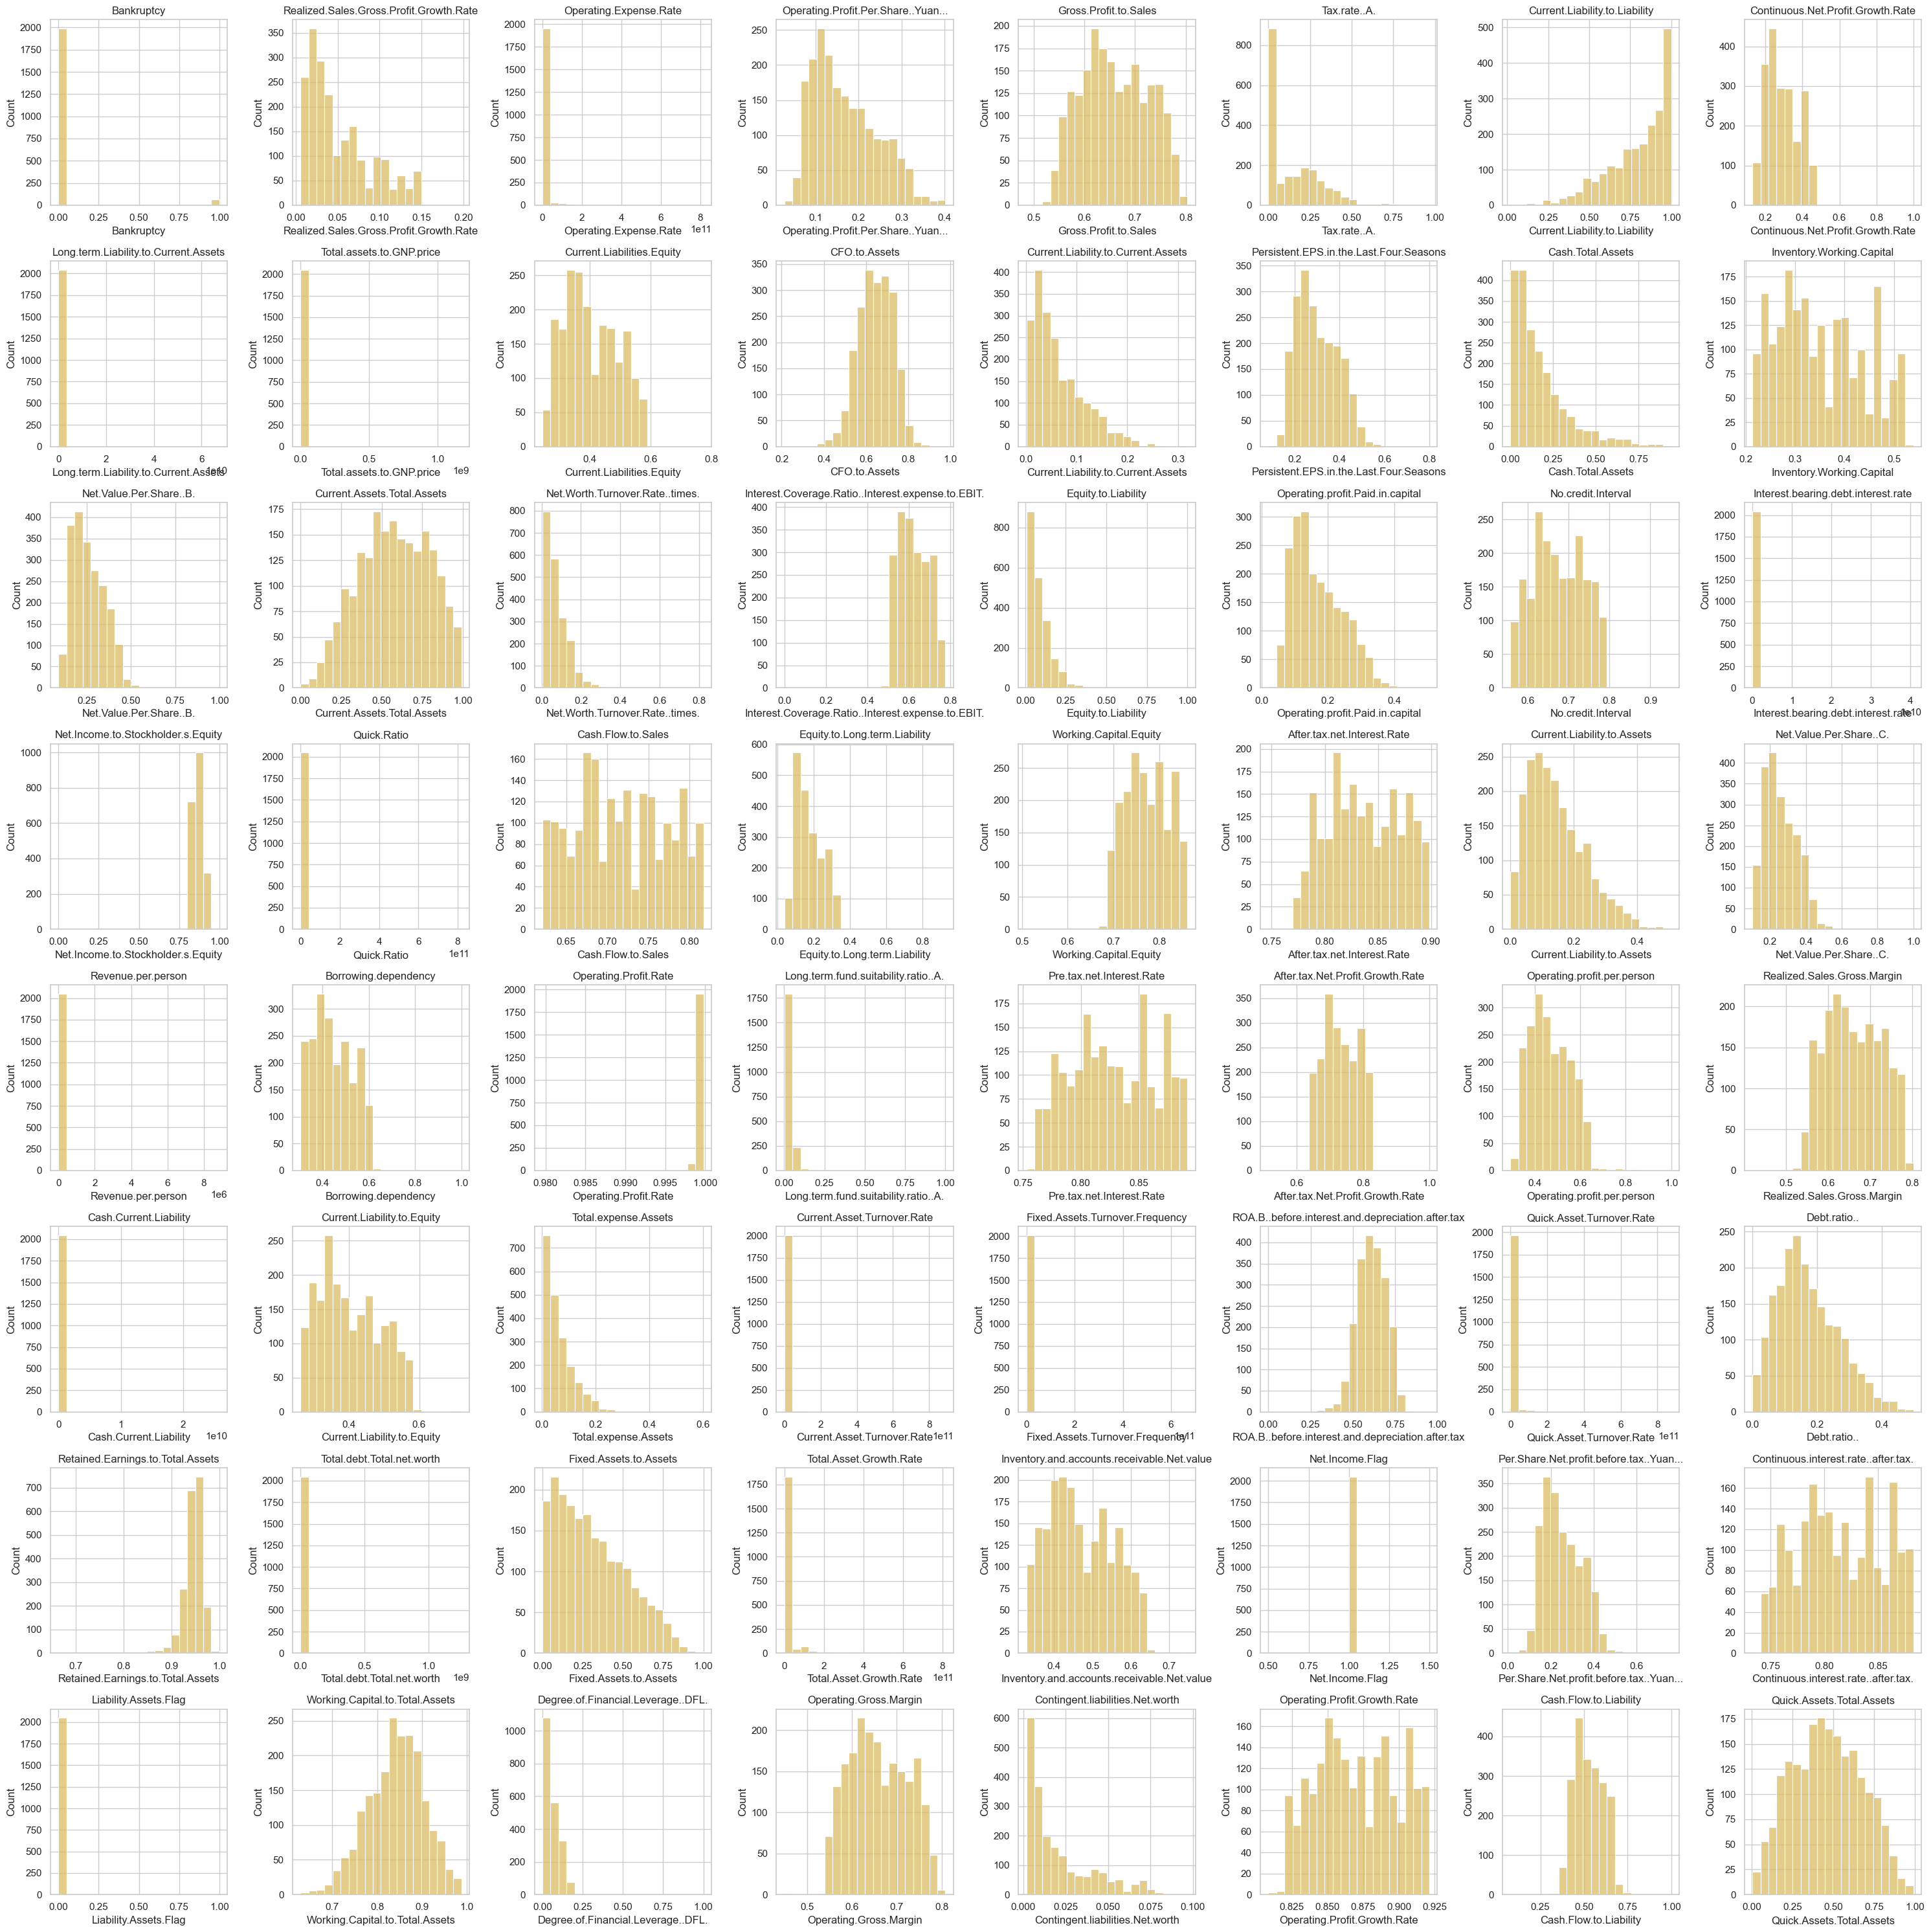

In [8]:
# Distribuciones de variables
columns_f = [col for col in train.columns if col != 'ID']

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
axes = axes.flatten()

# Graficar los histogramas para cada variable
for i, column in enumerate(columns_f):
    sns.histplot(train[column], kde=False, ax=axes[i], bins=20, color="#dcbb65")
    axes[i].set_title(column)

# Ajustar los márgenes para que las etiquetas no se solapen
plt.tight_layout()
plt.show()

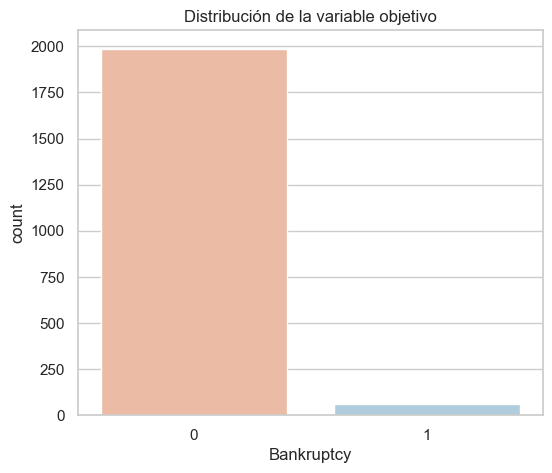

Tasa de bancarrota: 3.02%


In [9]:
# Distribución de la variable objetivo
plt.figure(figsize=(6, 5))  
sns.countplot(x='Bankruptcy', hue='Bankruptcy', data=train, palette='RdBu', legend=False)
plt.title('Distribución de la variable objetivo')
plt.show()

# Porcentaje de casos positivos (bancarrota)
bankrupt_rate = train['Bankruptcy'].mean()
print(f"Tasa de bancarrota: {bankrupt_rate:.2%}")

### Detección de valores faltantes

In [10]:
# Porcentaje de valores nulos por columna
nulls = train.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Series([], dtype: float64)

In [11]:
# Validar duplicados exactos (todas las columnas)
duplicados = train.duplicated()
print(f"Número de registros duplicados: {duplicados.sum()}")


Número de registros duplicados: 0


### Valores atípicos

In [12]:
# Selección de variables numéricas (excluyendo la variable objetivo)
variables_numericas = train.drop(columns=['Bankruptcy', 'Net.Income.Flag']).select_dtypes(include='number').columns

# Función para detectar valores atípicos usando el rango intercuartílico (IQR)
def detectar_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers.shape[0]

# Número de valores atípicos por columna
outliers_por_col = {col: detectar_outliers_iqr(train, col) for col in variables_numericas}
outliers_df = pd.DataFrame.from_dict(outliers_por_col, orient='index', columns=['N_outliers'])
outliers_df.sort_values(by='N_outliers', ascending=False)


N_outliers
Operating.Expense.Rate                  485
Quick.Asset.Turnover.Rate               463
Fixed.Assets.Turnover.Frequency         417
Current.Asset.Turnover.Rate             400
Total.Asset.Growth.Rate                 383
...                                     ...
Cash.Flow.to.Sales                        0
Current.Assets.Total.Assets               0
Inventory.Working.Capital                 0
Gross.Profit.to.Sales                     0
Quick.Assets.Total.Assets                 0

[63 rows x 1 columns]

### Correlaciones

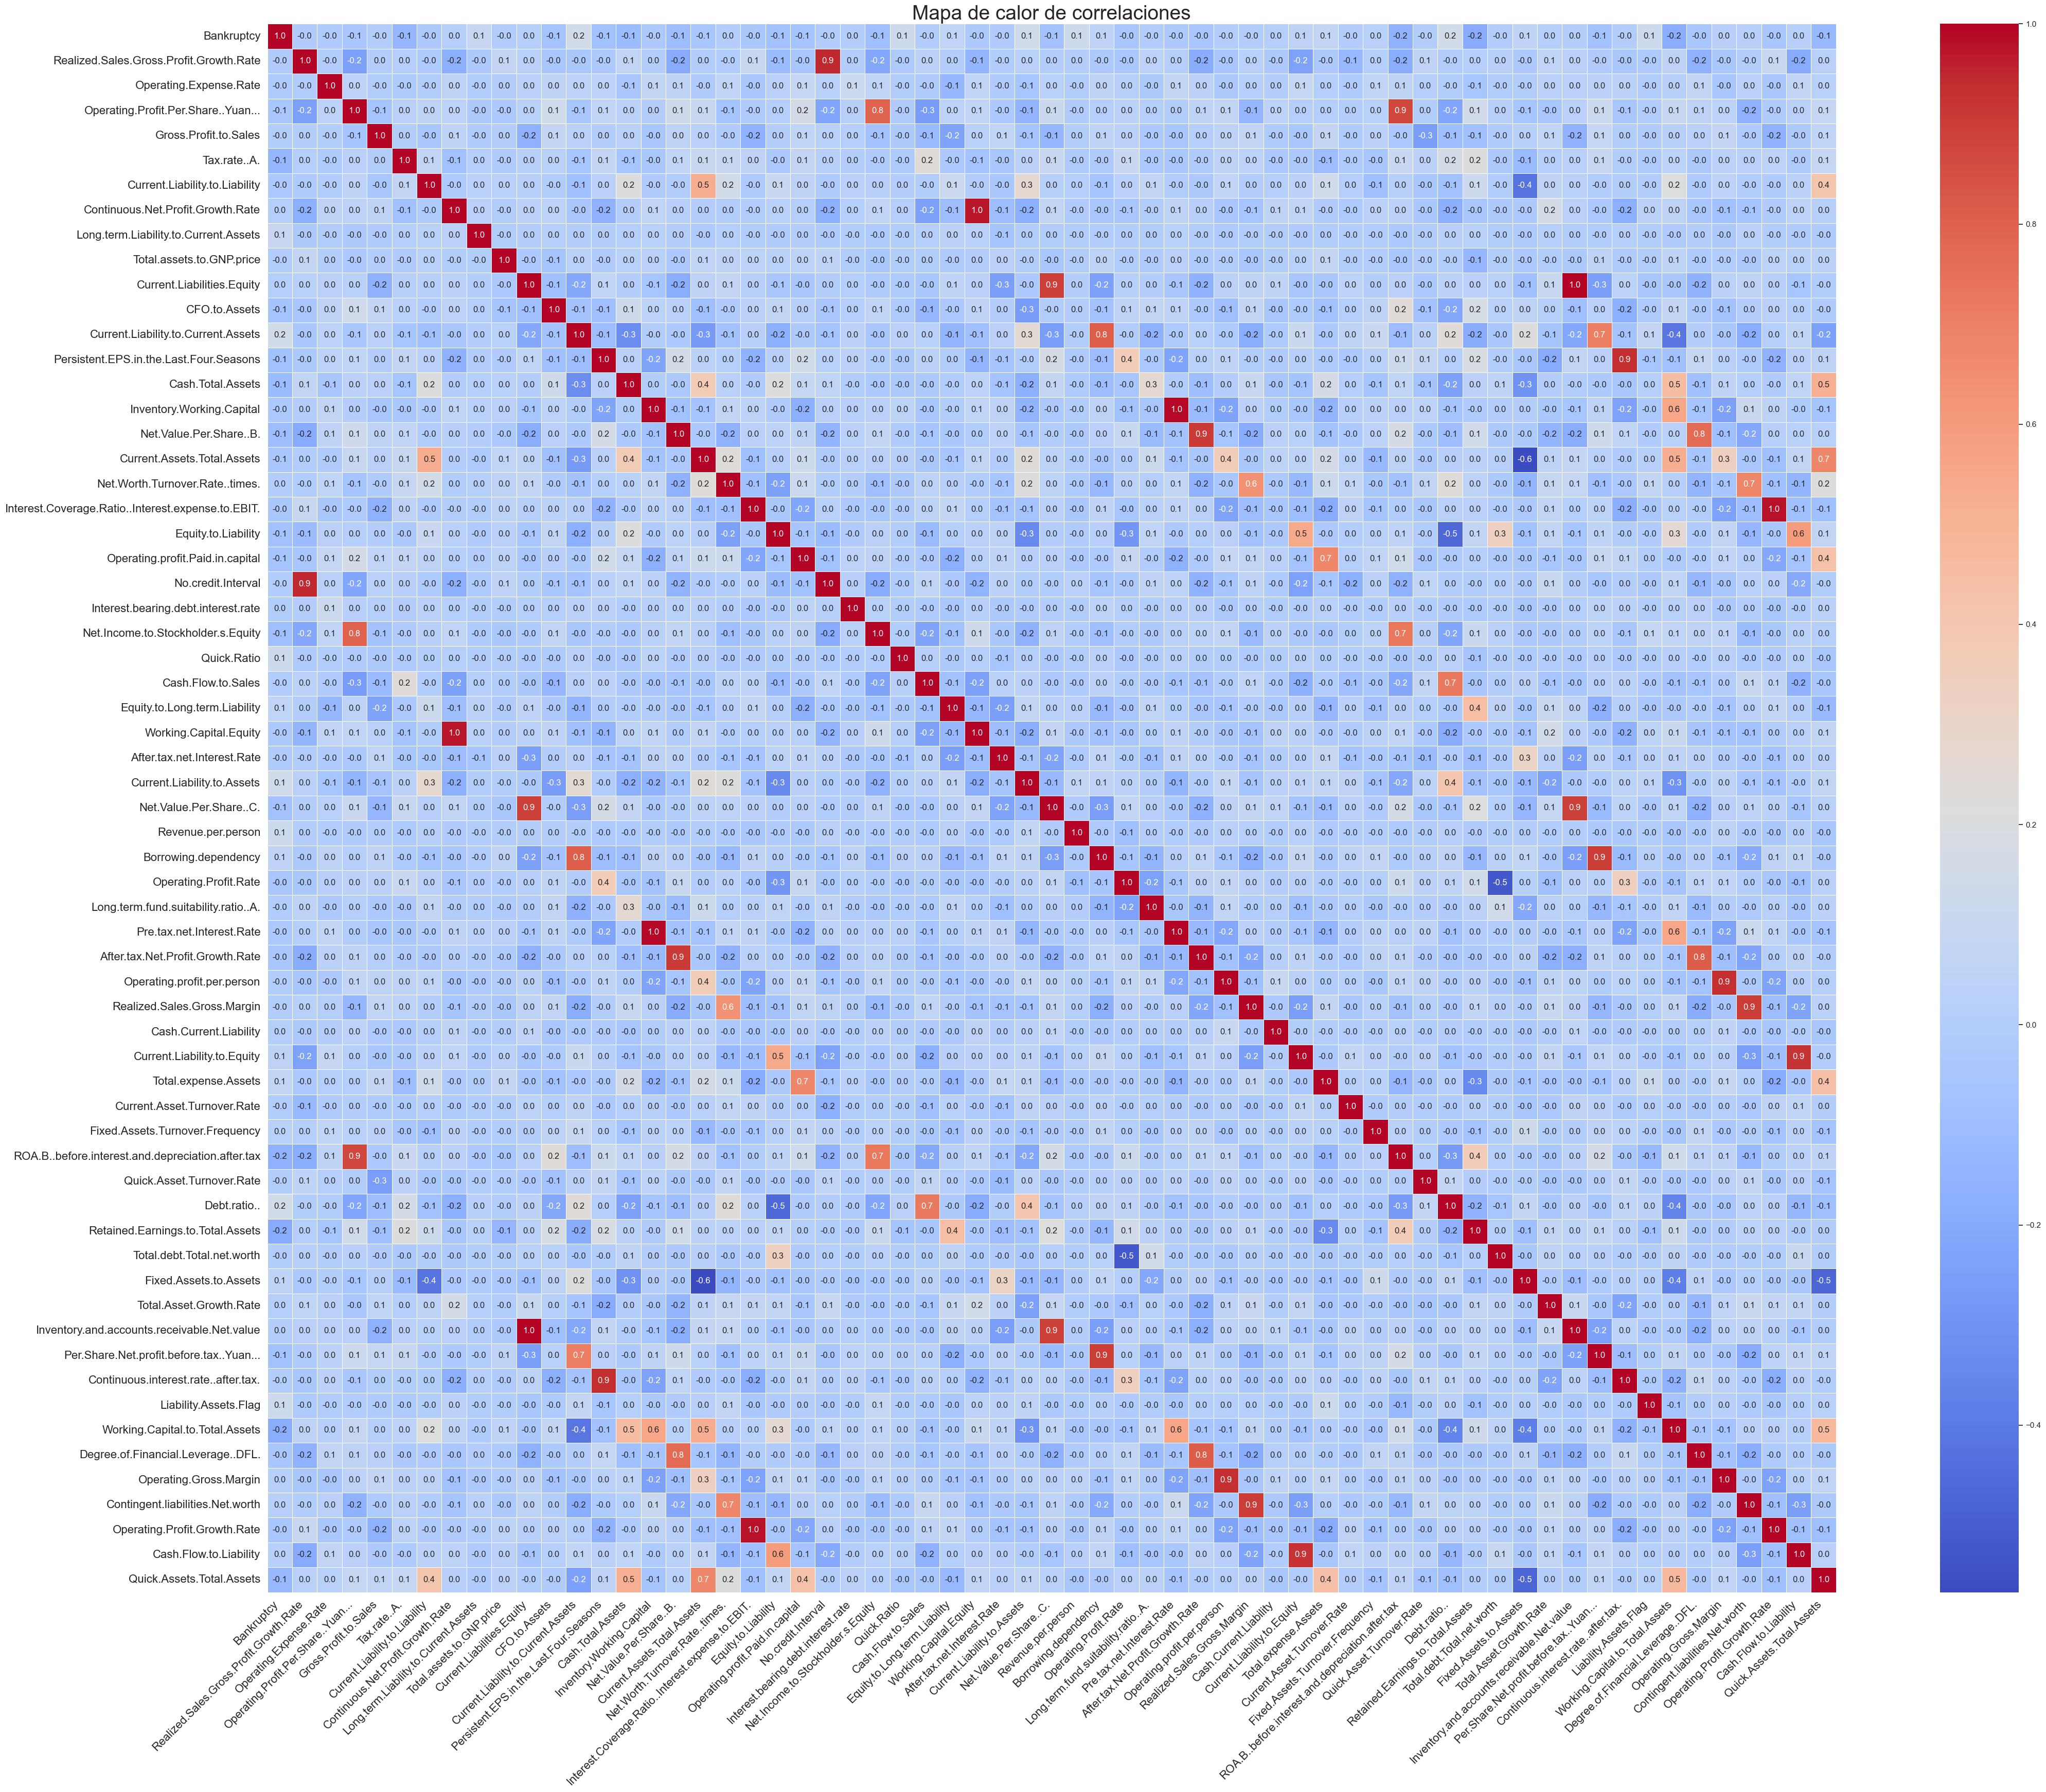

In [13]:
# Mapa de calor de correlaciones
plt.figure(figsize=(45, 35))
corr_matrix = train.drop(columns=['ID', 'Net.Income.Flag']).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".1f", cbar=True, 
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, 
            square=True, linewidths=0.5)

plt.xticks(rotation=45, ha="right", fontsize=16) 
plt.yticks(rotation=0, fontsize=16)
plt.title("Mapa de calor de correlaciones", fontsize=28)
plt.tight_layout()
plt.show()

#### Correlaciones entre variables predictoras

In [14]:
# Matriz de correlación alta (superior a 0.90)
cor_matrix = train[variables_numericas].corr().abs()
alta_cor = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
pares_altamente_correlacionados = [(col, alta_cor[col].idxmax(), alta_cor[col].max()) 
                                   for col in alta_cor.columns if alta_cor[col].max() > 0.90]

print("Pares de variables altamente correlacionadas (> 0.90):")
for par in pares_altamente_correlacionados:
    print(f"{par[0]} y {par[1]} — Correlación: {par[2]:.2f}")


Pares de variables altamente correlacionadas (> 0.90):
No.credit.Interval y Realized.Sales.Gross.Profit.Growth.Rate — Correlación: 0.95
Working.Capital.Equity y Continuous.Net.Profit.Growth.Rate — Correlación: 0.97
Pre.tax.net.Interest.Rate y Inventory.Working.Capital — Correlación: 0.99
After.tax.Net.Profit.Growth.Rate y Net.Value.Per.Share..B. — Correlación: 0.91
Inventory.and.accounts.receivable.Net.value y Current.Liabilities.Equity — Correlación: 1.00
Continuous.interest.rate..after.tax. y Persistent.EPS.in.the.Last.Four.Seasons — Correlación: 0.93
Operating.Gross.Margin y Operating.profit.per.person — Correlación: 0.93
Operating.Profit.Growth.Rate y Interest.Coverage.Ratio..Interest.expense.to.EBIT. — Correlación: 0.98
Cash.Flow.to.Liability y Current.Liability.to.Equity — Correlación: 0.92


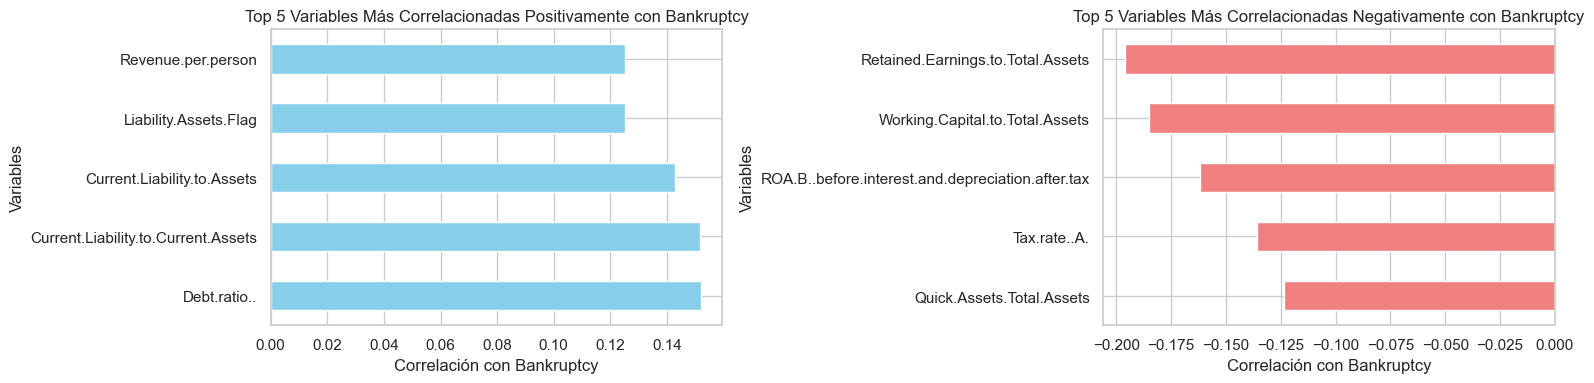

In [15]:
# Calcular la correlación con la variable 'Bankruptcy' y ordenar las variables
cor_target = train.corr()["Bankruptcy"].sort_values(ascending=False)
cor_target.drop(['ID', 'Bankruptcy', 'Net.Income.Flag'], inplace=True)

# Crear los subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # 1 fila, 2 columnas

# Subgráfico 1: Las 5 variables más correlacionadas positivamente con 'Bankruptcy'
cor_target.head(5).plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Variables Más Correlacionadas Positivamente con Bankruptcy')
axes[0].set_xlabel('Correlación con Bankruptcy')
axes[0].set_ylabel('Variables')

# Subgráfico 2: Las 5 variables más correlacionadas negativamente con 'Bankruptcy'
cor_target.tail(5).plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Top 5 Variables Más Correlacionadas Negativamente con Bankruptcy')
axes[1].set_xlabel('Correlación con Bankruptcy')
axes[1].set_ylabel('Variables')

plt.tight_layout()
plt.show()


Graficos de variables seleccionadas

Generando y guardando boxplots...



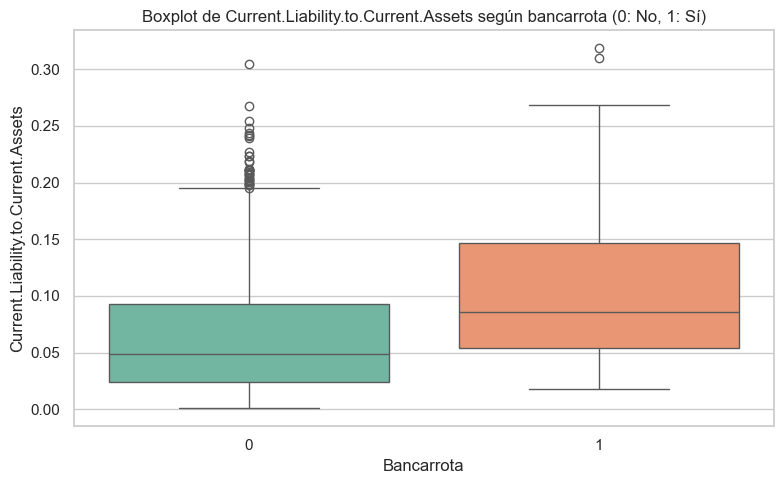

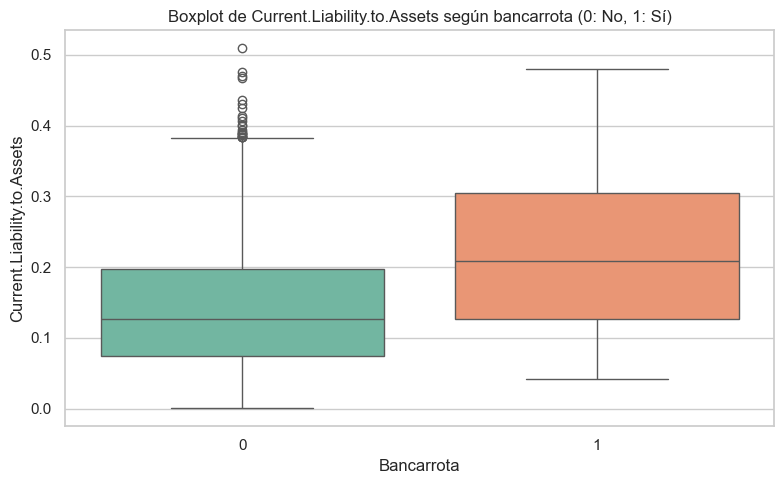

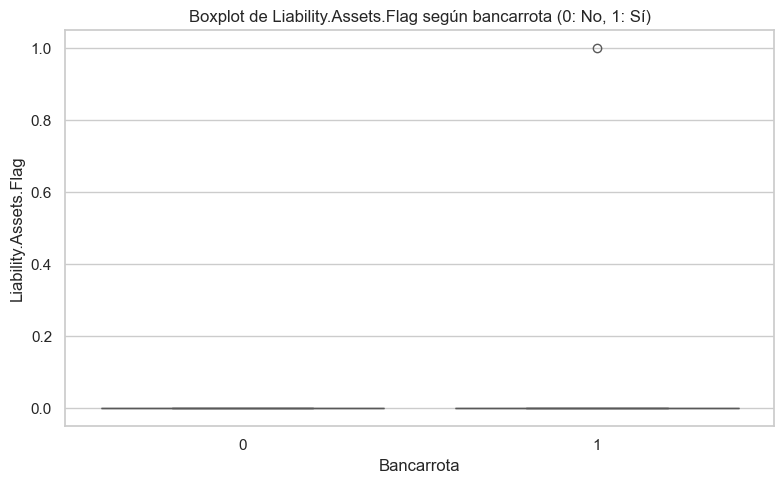

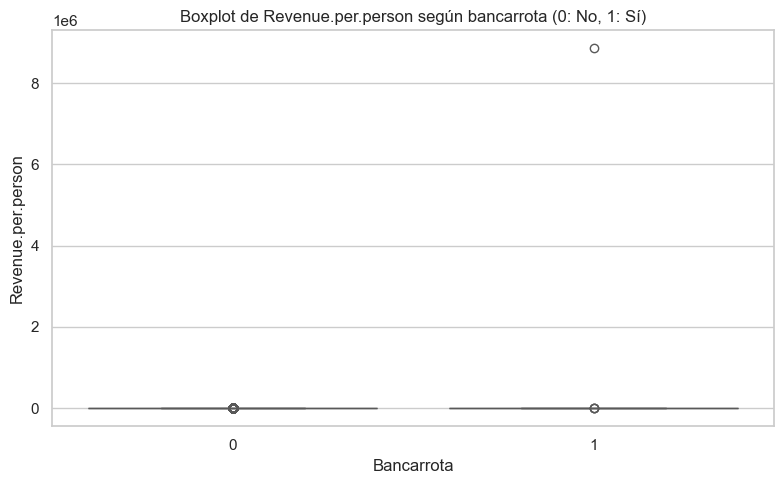

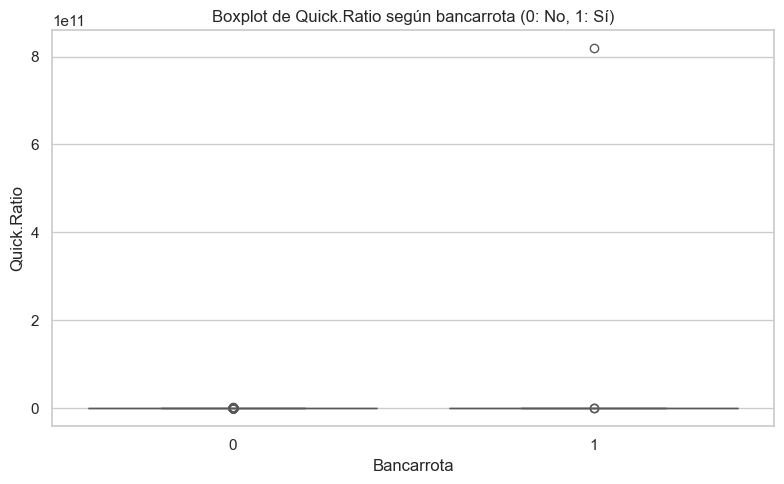

In [16]:
# Seleccionamos las 5 variables más correlacionadas con 'Bankruptcy'
variables_interes = cor_target[1:6].index.tolist()

# Boxplots
print("Generando y guardando boxplots...\n")
for variable in variables_interes:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=train,
        x='Bankruptcy',
        y=variable,
        hue='Bankruptcy',
        palette='Set2',
        legend=False
    )
    plt.title(f'Boxplot de {variable} según bancarrota (0: No, 1: Sí)')
    plt.xlabel('Bancarrota')
    plt.ylabel(variable)
    plt.tight_layout()
    plt.show()  # Mostrar la figura para visualizarla en el notebook
    plt.close()  # Cerrar la figura para liberar memoria


Generando y guardando histogramas...



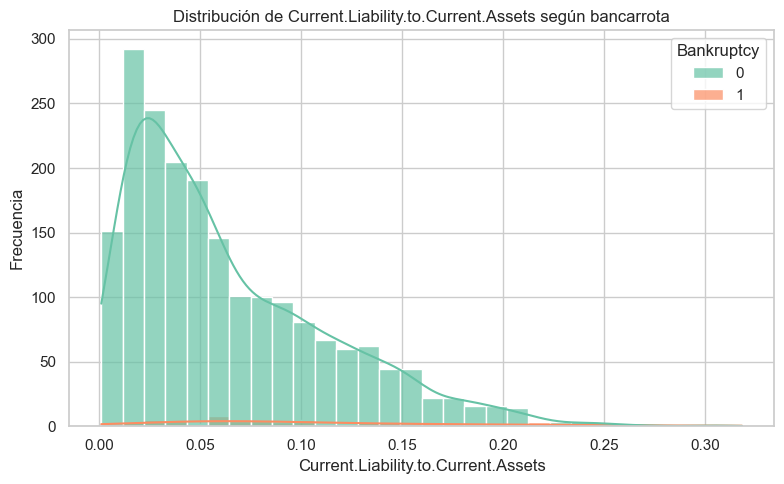

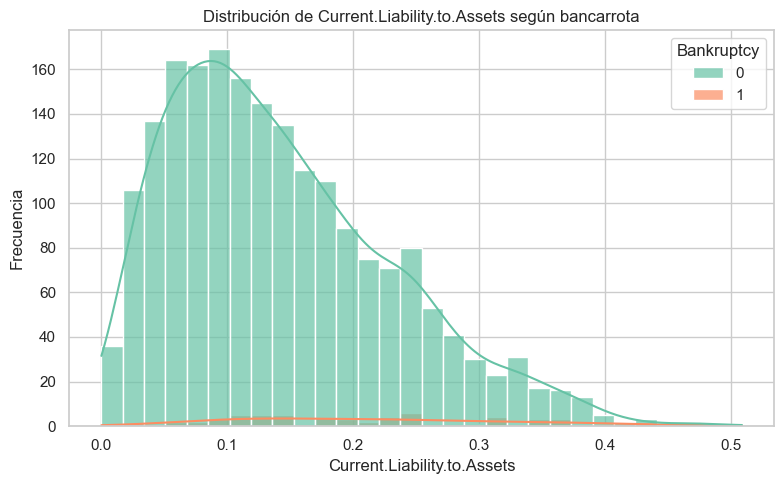

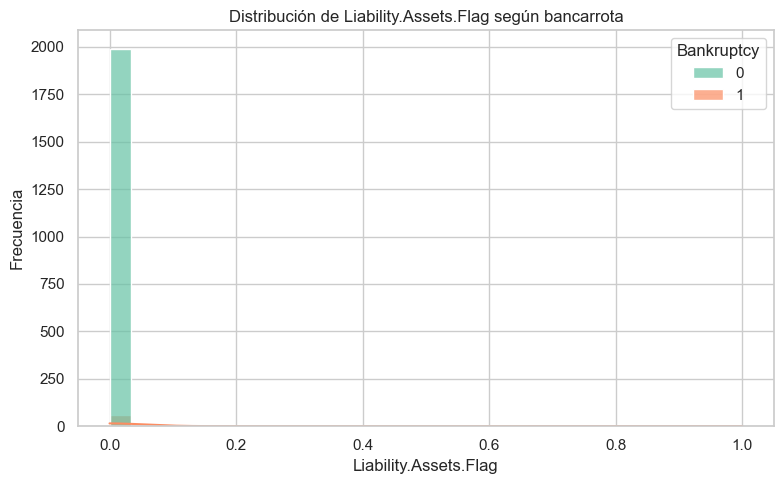

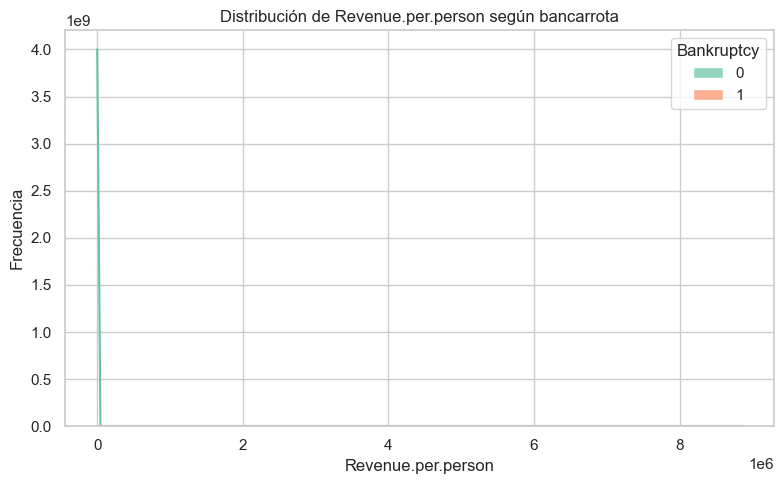

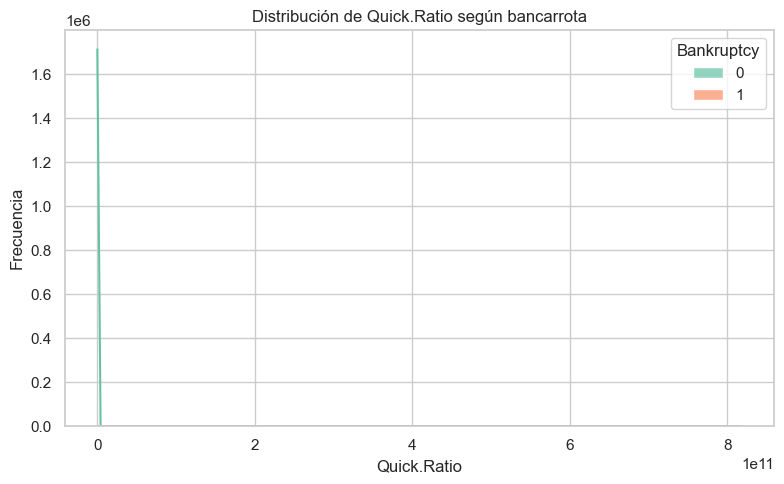

In [17]:
# Histogramas
print("Generando y guardando histogramas...\n")
for variable in variables_interes:
    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=train,
        x=variable,
        hue='Bankruptcy',
        bins=30,
        kde=True,
        palette='Set2',
        alpha=0.7
    )
    plt.title(f'Distribución de {variable} según bancarrota')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    #plt.savefig(f"../outputs/figures/histogram_{variable}.png")
    plt.show()  # Mostrar la figura para visualizarla en el notebook
    plt.close()  # Cerrar la figura para liberar memoria

 Validaciones calidad de datos


In [18]:
# Revisar columnas con posibles restricciones lógicas (ej. solo valores positivos)
variables_potencialmente_positivas = [
    'Operating.Profit.Per.Share..Yuan...',
    'Revenue.per.person',
    'Operating.profit.per.person',
    'Cash.Total.Assets'
]

for col in variables_potencialmente_positivas:
    print(f"{col}: valores <= 0 = {(train[col] <= 0).sum()}")


Operating.Profit.Per.Share..Yuan...: valores <= 0 = 0
Revenue.per.person: valores <= 0 = 0
Operating.profit.per.person: valores <= 0 = 0
Cash.Total.Assets: valores <= 0 = 0


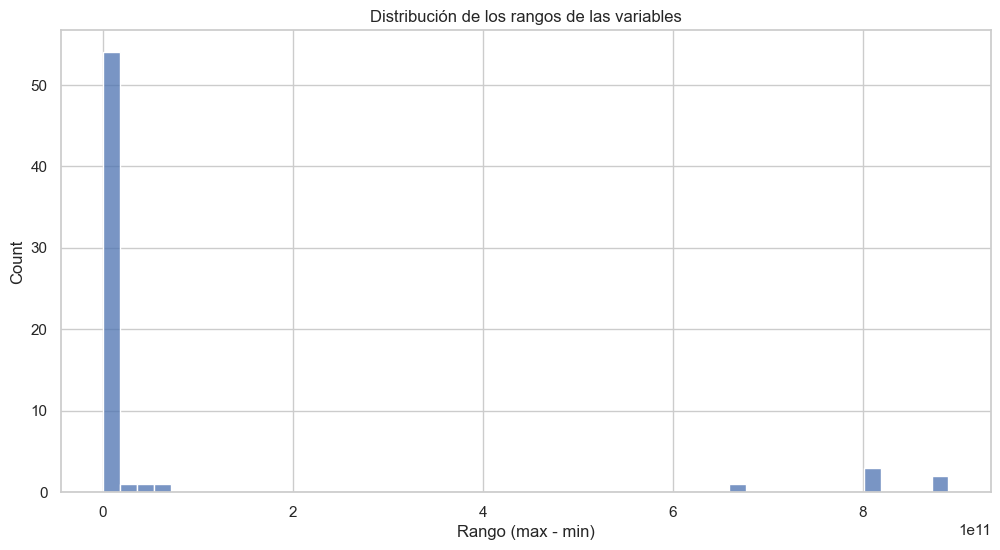

In [19]:
# Revisión de escalas muy dispares (rangos extremos)
# Rango = max - min
rangos = train.drop(columns=['ID', 'Bankruptcy']).apply(lambda x: x.max() - x.min())
rangos.sort_values(ascending=False).head(10)  # Rangos más altos

# Histograma de los rangos
plt.figure(figsize=(12, 6))
sns.histplot(rangos, bins=50)
plt.title('Distribución de los rangos de las variables')
plt.xlabel('Rango (max - min)')
plt.show()
plt.close()  # Cerrar la figura para liberar memoria

### **Conclusiones etapa 1: Exploración**
- El dataset de train contiene 2050 datos y 65 columnas (inclyyendo a la variable objetivo "Bankruptcy" de naturaleza binaria), mientras que el dataset de test contiene 500 datos y 64 columnas.
- 61 columnas son continuas, mientras que las variables ID, Net.Income.Flag y Liability.Assets.Flag son de tipo entero. Sin embargo, debido a la naturaleza del problema, la variable ID no tiene relevancia. Por otro lado, Net.Income.Flag solo toma el valor 1, lo que la convierte en una variable sin capacidad informativa significativa. Finalmente, la variable Liability.Assets.Flag es de tipo binario. Por lo anterior, ID y Net.Income.Flag se eliminaran en la etapa de preprocesamiento.
- No se identificaron valores nulos ni registros duplicados en el conjunto de datos, por lo que no es necesario realizar un preprocesamiento adicional.
- La variable objetivo está desbalanceada (La tasa de bancarrota es solo del 3%), por lo que se considera usar técnicas de balanceo en la siguiente etapa.
- Al aplicar el rango intercuartílico (IQR), se identificaron valores atípicos en todas. Las 5 variables con el mayor número de valores atípicos son: Operating.Expense.Rate, Quick.Asset.Turnover.Rate, Fixed.Assets.Turnover.Frequency y Current.Asset.Turnover.Rate

###################### Mejorar
- Algunas razones financieras muestran correlación moderada con la variable objetivo.
- En cuanto a las correlaciones de las variables predictivas, se encontrar algunas relaciones significativas, por ejemplo entre No. Credit Interval y Operating.Expensive.Rate, Net.Income.to.Sotckholder.s.Equity y Gross.Profit.to.Sales, Working.Capital.Equity y 
- Se identifican algunas variables con distribuciones distintas entre empresas quebradas y no quebradas.

se argumenta la razón por la que el uso de estas variables puede contribuir a la solución del problema por medio de modelos predictivos

***
## 2. Preparación de los datos

En esta etapa, se aplican diversas técnicas de preprocesamiento para preparar los datos como insumo para el desarrollo de modelos predictivos.

### Ingeniería de variables
Considerando el contexto de la predicción de bancarrota y basándonos en la revisión bibliográfica, a continuación, se crean nuevas variables que podrían ser mejores predictores que las existentes.

Estas variables incluyen ratios financieros, indicadores de solvencia y apalancamiento, además de medidas de eficiencia operativa y volatilidad.

- **Ratios financieros:**
(Z-score modificado de Altman, Capital de Trabajo sobre Activos Totales - Working Capital to Total Assets)
Son cálculos derivados de las principales cuentas financieras de la empresa, se utilizaron lo más usados en el análisis de bancarrota.

- **Indicadores de solvencia:**
(Apalancamiento extendido, Ratio de Solvencia - Equity to Liability, Stress Financiero - Pasivos Corrientes a Activos Líquidos) Miden la capacidad de una empresa para cumplir con sus obligaciones financieras a largo plazo, ya que una empresa con alta deuda es más susceptible a la bancarrota.

- **Eficiencia Operativa**
(Cambio en margen bruto vs margen operativo, Rentabilidad sobre ventas - Operating Profit Rate). Mide la habilidad de la empresa para utilizar sus recursos de manera eficiente para generar ganancias

- **Volatilidad:**
(Volatilidad del EPS - Earnings Per Share) Es una medida de la variabilidad o inestabilidad de las ganancias de una empresa a lo largo del tiempo

In [20]:
def extend_features(df): 
    # RATIOS FINANCIEROS
    # Z-score modificado de Altman
    df['Z_score_modificado'] = (
        1.2 * df['Working.Capital.to.Total.Assets'] +
        1.4 * df['Retained.Earnings.to.Total.Assets'] +
        3.3 * df['Operating.Profit.Rate'] +
        0.6 * df['Equity.to.Liability'] +
        1.0 * df['Revenue.per.person']  # Ajustado como proxy de ventas/activos
    )

    # Capital de trabajo neto sobre activos totales
    df['Capital_Trabajo_Ratio'] = (df['Current.Assets.Total.Assets'] - df['Current.Liability.to.Assets'])

    # INDICADORES DE SOLVENCIA
    # Apalancamiento extendido
    df['Apalancamiento_Extendido'] = df['Total.debt.Total.net.worth'] + df['Contingent.liabilities.Net.worth']

    # Ratio de cobertura de obligaciones financieras
    df['Cobertura_Deuda'] = df['Operating.Profit.Rate'] / (df['Interest.bearing.debt.interest.rate'] + 1e-6)

    # Indicador de estrés financiero: pasivos corrientes vs activos líquidos
    df['Stress_Financiero'] = df['Current.Liability.to.Current.Assets'] / (df['Cash.Total.Assets'] + 1e-6)

    # Relación de liquidez con obligaciones: flujo de caja vs pasivos
    df['Liquidez_vs_Pasivos'] = df['Cash.Flow.to.Liability'] - df['Interest.Coverage.Ratio..Interest.expense.to.EBIT.']

    # EFICIENCIA OPERATIVA
    # Cambio en margen bruto vs margen operativo (eficiencia operativa)
    df['Cambio_Margen_Bruto'] = df['Gross.Profit.to.Sales'] - df['Operating.Gross.Margin']

    # Bandera de alerta si flujo operativo es bajo y ratio de deuda alto
    df['Bandera_Bajo_Flujo_Operativo'] = np.where(
        (df['Cash.Flow.to.Sales'] < 0.05) & (df['Debt.ratio..'] > 0.7),
        1, 0) 

    # Margen de beneficio después de impuestos
    df['Margen_Neto_Post_Impuestos'] = df['After.tax.Net.Profit.Growth.Rate'] / (df['Operating.Profit.Rate'] + 1e-6)

    # VOLATILIDAD
    # Variación de utilidad por acción entre temporadas (estabilidad)
    df['Volatilidad_EPS'] = df['Persistent.EPS.in.the.Last.Four.Seasons'].rolling(window=4, min_periods=1).std()
    
    return df

In [21]:
# Agregar nuevas variables
train = extend_features(train)
test = extend_features(test)

#### Verificación de valores vacíos
Debido a la creación de nuevas variables, se verifica si quedaron valores vacíos.

In [22]:
# Porcentaje de valores nulos por columna dataset de train
nulls = train.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])

# Porcentaje de valores nulos por columna dataset de test
nulls = test.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])

Volatilidad_EPS    0.000488
dtype: float64
Volatilidad_EPS    0.002
dtype: float64


#### Imputación de valores vacíos: Median imputer

In [23]:
# Separar features y target para que al imputar tengan las mismas columnas
X = train.drop(columns=["Bankruptcy", "Net.Income.Flag", "ID"])
y = train["Bankruptcy"]

# Guardar ID del test para el submission
test_ids = test["ID"]
X_test = test.drop(columns=["Net.Income.Flag", "ID"])
X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)

# Crear el imputer usando la mediana
median_imputer = SimpleImputer(strategy='median')

# Aplicar el imputer a los dataset de train y test
X_train_imputed = pd.DataFrame(median_imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(median_imputer.transform(X_test), columns=X.columns)

### División en datos de entrenamiento y validación

Se divide el set de train en entrenamiento y validación, asignando un porcentaje de 80% y 20%, respectivamente.

In [24]:
# Dividir dataset de train en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_imputed, y, test_size=0.2, stratify=y, random_state=42)

### Normalización de los datos

In [25]:
# Escalar los datos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_imputed)

### Balanceo: SMOTE

In [26]:
# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

### Selección de variables

Para la selección de variables se emplearan dos enfoques:

1. **Análisis de Componentes Principales (PCA):** Se utilizará PCA para reducir la dimensionalidad del conjunto de datos, identificando las combinaciones lineales más significativas de las variables.

2. **Importancia de las variables mediante XGBoost Classifier:** Se aplicará este potente algoritmo de árboles de decisión, para evaluar la importancia de cada variable en la predicción del objetivo. Este método utiliza el análisis de los "pesos o ganancias" obtenidos por cada característica en el proceso de entrenamiento para identificar cuáles son las variables que contribuyen más significativamente al rendimiento del modelo.

#### 1. Análisis de Componentes Principales (PCA)

In [27]:
# Inicializamos PCA
pca = PCA(n_components=0.95)

# Ajuste y transformación de los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_scaled)

# Transformación los datos de validación y prueba
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

#### 2. Importancia de las variables mediante XGBoost Classifier

In [28]:
def importance_XGBoost(X_train, y_train):
    # Entrenar el modelo
    xgb_model = XGBClassifier(random_state=42, tree_method="hist", device="cuda", eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # Obtener la importancia por 'weight' o pesos
    feature_important = xgb_model.get_booster().get_score(importance_type='weight')

    # Extraer claves (f0, f1, etc) y valores
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    # Crear el DataFrame de importancia
    importance_df = pd.DataFrame({
        'feature_code': keys,
        'weight_importance': values
    })

    # Mapear de f0, f1, ... a los nombres reales de las columnas
    feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
    importance_df['feature_name'] = importance_df['feature_code'].map(feature_map)

    # Ordenar por importancia
    importance_df = importance_df.sort_values(by='weight_importance', ascending=False)

    return importance_df, xgb_model

In [29]:
importance_df, xgb_model = importance_XGBoost(X_train_scaled, y_train)
# importance_df, xgb_model = importance_XGBoost(X_train_bal, y_train_bal)

c:\Users\Usuario\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:729: UserWarning: [22:24:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


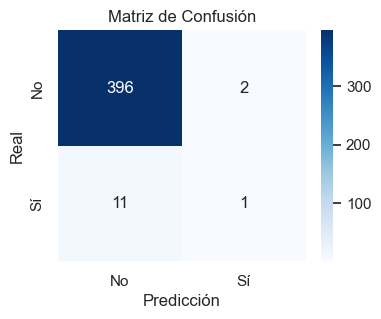

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       398
           1       0.33      0.08      0.13        12

    accuracy                           0.97       410
   macro avg       0.65      0.54      0.56       410
weighted avg       0.95      0.97      0.96       410

ROC AUC Score: 0.8876


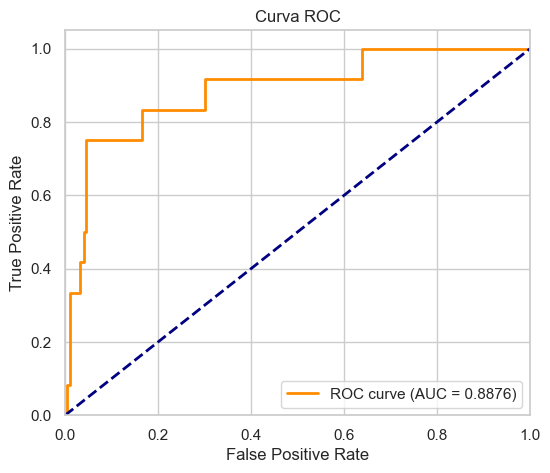

In [30]:
# Predicción sobre el set de validación
y_pred = xgb_model.predict(X_val_scaled)

# Evaluación del modelo
# Matriz de Confusión
plt.figure(figsize=(4, 3)) 
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])

plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reporte de Clasificación
class_report = classification_report(y_val, y_pred)
print("Reporte de Clasificación:")
print(class_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, xgb_model.predict_proba(X_val_scaled)[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


########### Sin balanceo

In [31]:
# Filtrar las variables que superan el umbral de 5 de importancia
threshold = 5
selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# Subconjunto de datos con esas variables
X_train_sub = X_train_scaled_df[selected_features]
X_valid_sub = X_val_scaled_df[selected_features]

len(selected_features)

40

######## Balanceo

In [32]:
# # Filtrar las variables que superan el umbral de 5 de importancia
# threshold = 9
# selected_features = importance_df[importance_df['weight_importance'] > threshold]['feature_name'].tolist()

# X_train_scaled_df = pd.DataFrame(X_train_bal, columns=X_train_imputed.columns)
# X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train_imputed.columns)

# # Subconjunto de datos con esas variables
# X_train_sub = X_train_scaled_df[selected_features]
# X_valid_sub = X_val_scaled_df[selected_features]

# len(selected_features)
# y_train = y_train_bal


***
## 3. Análisis preliminar de selección de modelos

#### Sin balanceo
1. XGBoost o LightGBM

Son potentes para datos tabulares y permiten ajustar scale_pos_weight (XGBoost) o is_unbalance (LightGBM) para corregir el desbalance.

Además, manejan bien relaciones no lineales y muchas variables.

✅ 2. Random Forest con ajuste de pesos

Usa class_weight='balanced' en RandomForestClassifier.

Resistente a ruido y overfitting, muy buena opción cuando tienes muchas variables (como tus 63 razones financieras).

✅ 3. Logistic Regression con regularización + class_weight

LogisticRegression(class_weight='balanced').

Un modelo base muy interpretativo, bueno para establecer una línea base y entender la importancia de variables.

✅ 4. Support Vector Machine (SVM) con class_weight='balanced'

SVM suele ser fuerte en problemas desbalanceados si ajustas bien los parámetros (C y el kernel).

Aunque ojo: puede ser más costoso computacionalmente si tienes muchísimos datos.

✅ 5. Redes Neuronales pequeñas + técnicas como focal loss

Si quieres usar redes, podrías usar una red neuronal pequeña y cambiar la función de pérdida a una como focal loss, que enfoca más el aprendizaje en las clases minoritarias.

✅ 6. Algoritmos de Muestreo + Modelos Simples

Aplicar SMOTE, ADASYN o undersampling para balancear primero, y luego usar modelos como:

Logistic Regression

Random Forest

XGBoost

- Evalúa:

Confusion Matrix

ROC-AUC

F1-Score

#### Balanceado
XGBoost o LightGBM

Son excelentes con datos tabulares como el tuyo.

Capturan relaciones no lineales.

Son rápidos y muy buenos con variables numéricas como razones financieras.

Random Forest

Súper sólido, maneja muchas variables sin necesidad de preselección complicada.

Resistente al overfitting si ajustas hiperparámetros (max_depth, n_estimators).

Redes Neuronales Pequeñas (MLPClassifier)

Si quieres experimentar algo más "deep learning", un MLP (Multi-Layer Perceptron) pequeño funciona bien ahora que el dataset está balanceado.

Cuidado con sobreajustar si la red es muy grande.

Support Vector Machine (SVM)

Si tienes pocas muestras o no demasiadas observaciones, un SVM puede ser muy efectivo.

Escala bien si las variables están normalizadas.

Regresión Logística

Sigue siendo buena para una baseline rápida y como referencia para otros modelos.

***
## 4. Desarrollo y calibración de modelos

Debido a los requerimientos del proyecto, únicamente se permite el uso de redes neuronales tipo MLP (Perceptrón Multicapa). Por tanto, en esta sección se procede a la calibración de este tipo de modelos.

### Diseño de la arquitectura de la red MLP y compilación del modelo: Modelo base

Previamente se realizaron diversas pruebas exploratorias para determinar la arquitectura más adecuada de la red neuronal MLP. Los resultados mostraron que los modelos con menos capas ocultas tendían a tener mejor desempeño, probablemente debido a la cantidad moderada de datos (se disminuyó con las división de train y validación) y la disminución del número de variables predictivas.

A continuación, se define un modelo base de red neuronal compuesta por 2 capas ocultas con 64 y 32 neuronas respectivamente (balance entre representación y simplicidad), utilizando la función de activación ReLU (mitigar problema de desvanecimiento deel gradiente). La capa de salida es de una sola neurona con activación sigmoide, dado que se trata de un problema de clasificación binaria. El modelo se compiló con el optimizador Adam por su capacidad de adaptarse a los parámetros de entrenamiento, función de pérdida binary crossentropy y exactitud y auc como métrica de evaluación.

In [33]:
# Definir modelo base
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

history = model.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=50, 
    batch_size=32,
    verbose=0
)

In [34]:
def plot_training_history(history):
    # Graficar la pérdida (Loss)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Evolución de la función de pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar el AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Evolución del AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
def evaluacion_modelo(model, X_train, y_train, X_val, y_val):
    # Predicciones para el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_pred = (y_train_pred > 0.5)  # Convertir probabilidades en etiquetas binarias (0 o 1)
    
    # Predicciones para el conjunto de validación
    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5)  # Convertir probabilidades en etiquetas binarias (0 o 1)
    
    # Calcular métricas para ambos datasets
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_val = roc_auc_score(y_val, y_val_pred)
    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    # resultados
    print(f"F1-score (Train): {f1_train:.4f}")
    print(f"F1-score (Validation): {f1_val:.4f}")
    print(f"AUC (Train): {auc_train:.4f}")
    print(f"AUC (Validation): {auc_val:.4f}")
    
    # Graficar matrices de confusión
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matriz de Confusión - Entrenamiento')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Real')
    
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Matriz de Confusión - Validación')
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Real')
    
    plt.show()

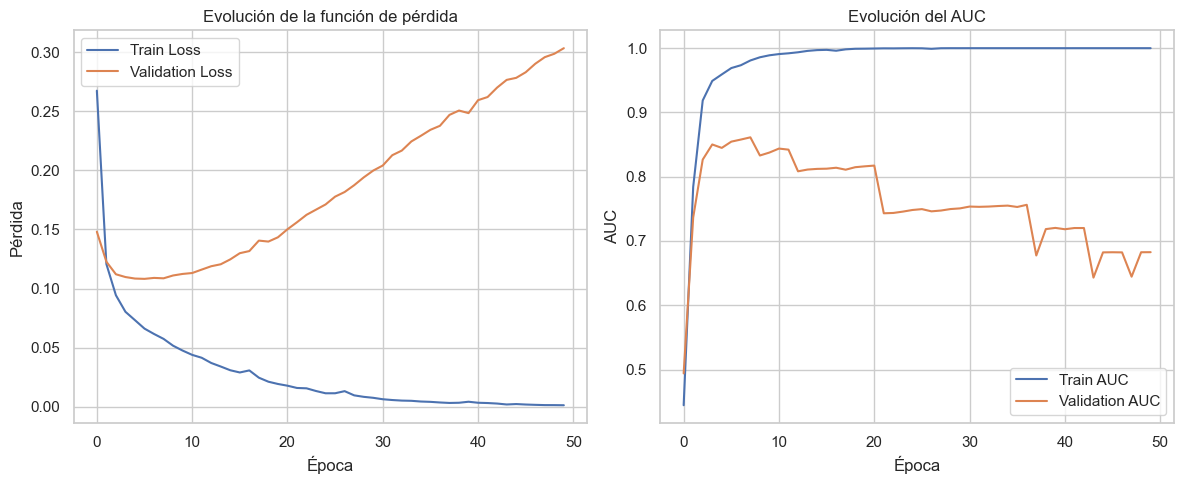

13/13 [==============================] - 0s 1ms/step
F1-score (Train): 1.0000
F1-score (Validation): 0.3478
AUC (Train): 1.0000
AUC (Validation): 0.6579


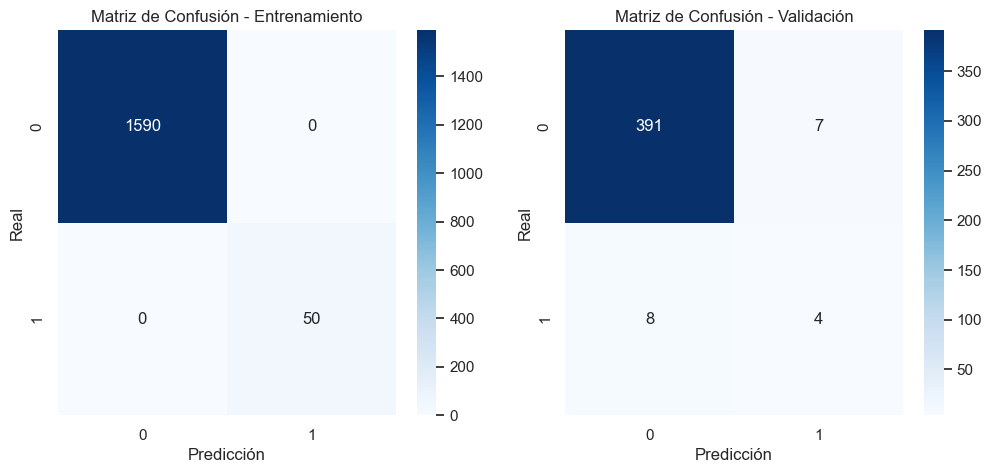

In [36]:
plot_training_history(history)
evaluacion_modelo(model, X_train_sub, y_train, X_valid_sub, y_val)

Tanto en las gráficas de evolución como en las métricas de evaluación, se observa que el modelo está experimentando overfitting. A pesar de que el modelo tiene un desempeño perfecto en el conjunto de entrenamiento, con un F1-score y un AUC de 1, su rendimiento en el conjunto de validación es significativamente más bajo.

Esto sugiere la incorporación de técnicas de regularización y el ajuste de los hiperparámetros.

### Modelo base + Incorporación de técnicas de regularización

In [37]:
# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

history = model.fit(
    X_train_sub, y_train,
    validation_data=(X_valid_sub, y_val),
    epochs=50, 
    batch_size=32,
    verbose=0
)

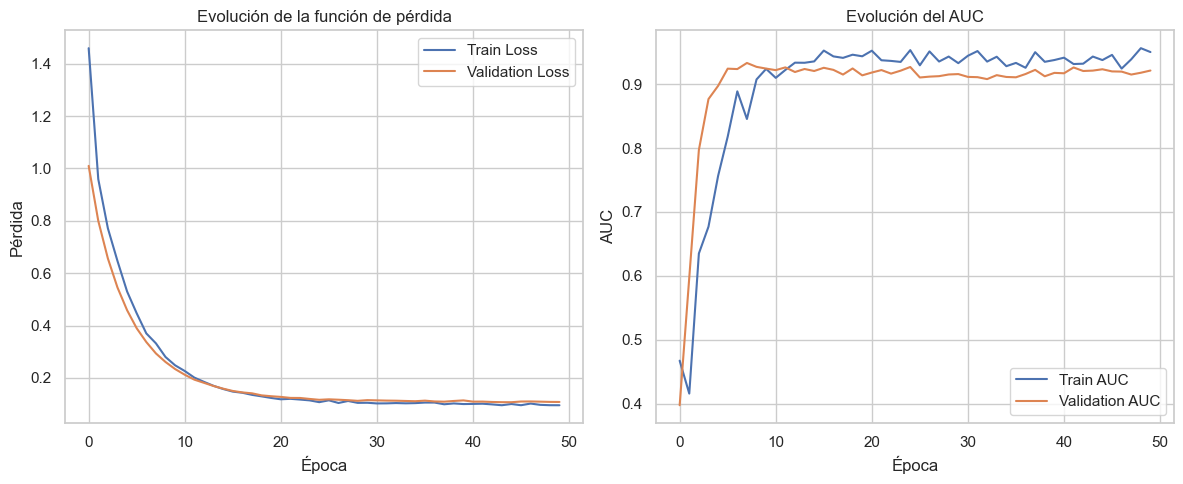

13/13 [==============================] - 0s 834us/step
F1-score (Train): 0.3871
F1-score (Validation): 0.1429
AUC (Train): 0.6200
AUC (Validation): 0.5404


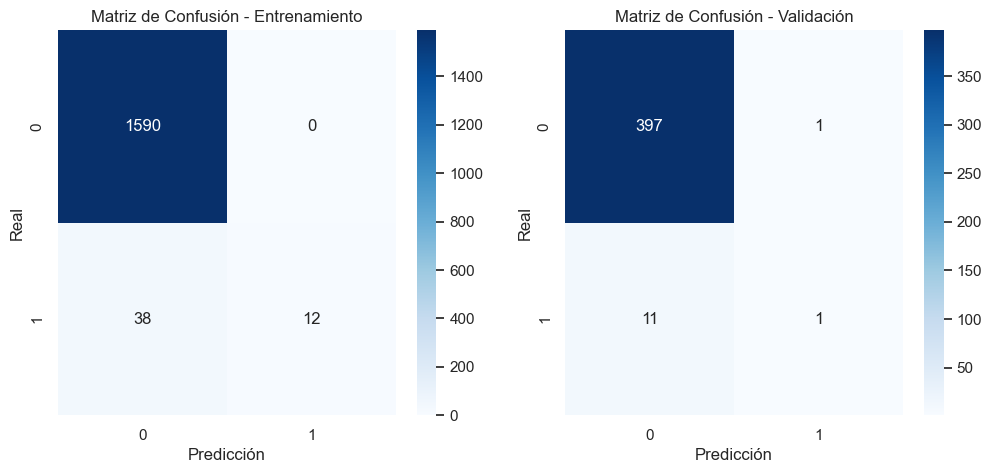

In [38]:
plot_training_history(history)
evaluacion_modelo(model, X_train_sub, y_train, X_valid_sub, y_val)

Con la incorporación de técnicas de regularización, como Dropout y regularización L2, el nuevo modelo muestra una mejora respecto al modelo base, ya que se logró controlar el overfitting. Sin embargo, aún existen áreas de oportunidad para optimizar el rendimiento. Aunque el desempeño es consistente entre el conjunto de entrenamiento y el de validación, ambos resultados siguen siendo relativamente bajos. Por lo tanto, el siguiente paso es realizar ajustes en los hiperparámetros para mejorar aún más la capacidad de generalización del modelo.

### Ajuste de hiperparámetros manual

Inicialmente, se llevó a cabo un ajuste manual de los hiperparámetros con el objetivo de comprender mejor la evolución de las métricas de la red neuronal. Durante este proceso, se variaron parámetros clave como el número de neuronas, la función de activación, la tasa de regularización para todas las capas, el dropout, la tasa de aprendizaje, el optimizador y el número de épocas. A continuación, se presentan algunas de las pruebas realizadas.

### Modelo final


Epoch 1/100
Train F1: 0.0058 | Val F1: 0.0

Epoch 2/100
Train F1: 0.0 | Val F1: 0.0

Epoch 3/100
Train F1: 0.0 | Val F1: 0.0

Epoch 4/100
Train F1: 0.0 | Val F1: 0.0

Epoch 5/100
Train F1: 0.0 | Val F1: 0.0

Epoch 6/100
Train F1: 0.0 | Val F1: 0.0

Epoch 7/100
Train F1: 0.0 | Val F1: 0.0

Epoch 8/100
Train F1: 0.0 | Val F1: 0.0

Epoch 9/100
Train F1: 0.0 | Val F1: 0.0

Epoch 10/100
Train F1: 0.0 | Val F1: 0.0

Epoch 11/100
Train F1: 0.0 | Val F1: 0.0

Epoch 12/100
Train F1: 0.0 | Val F1: 0.0

Epoch 13/100
Train F1: 0.0 | Val F1: 0.0

Epoch 14/100
Train F1: 0.0 | Val F1: 0.0

Epoch 15/100
Train F1: 0.0 | Val F1: 0.0

Epoch 16/100
Train F1: 0.0 | Val F1: 0.0

Epoch 17/100
Train F1: 0.0 | Val F1: 0.0

Epoch 18/100
Train F1: 0.0 | Val F1: 0.0

Epoch 19/100
Train F1: 0.0 | Val F1: 0.0

Epoch 20/100
Train F1: 0.0 | Val F1: 0.0

Epoch 21/100
Train F1: 0.0 | Val F1: 0.0

Epoch 22/100
Train F1: 0.0 | Val F1: 0.0

Epoch 23/100
Train F1: 0.0 | Val F1: 0.0

Epoch 24/100
Train F1: 0.0 | Val F1: 0.

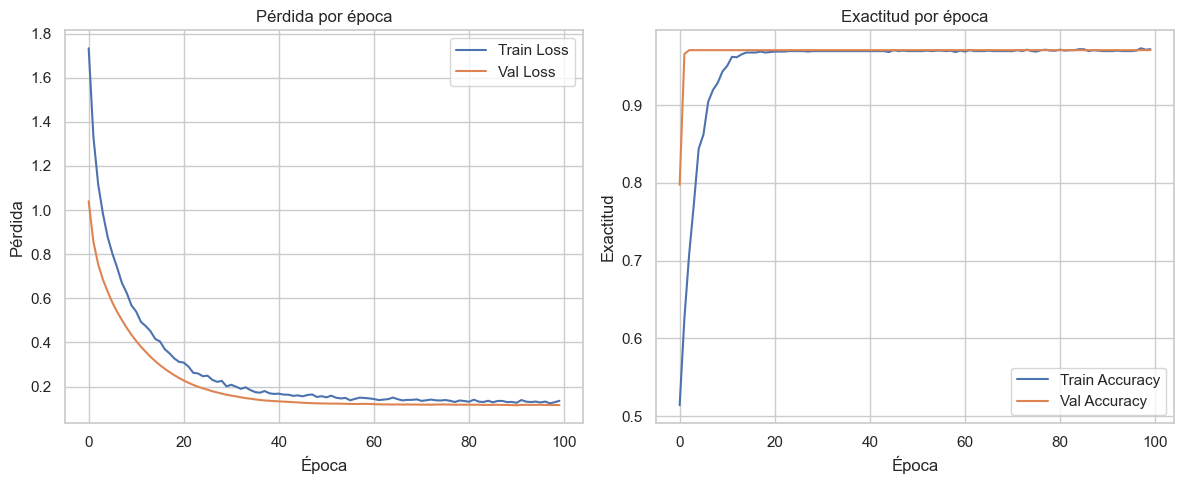

In [39]:
# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(40, activation='gelu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Disminuir L2 regularization
    layers.Dropout(0.8),  # Disminuir Dropout
    layers.Dense(20, activation='silu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),  # L2 regularization
    layers.Dropout(0.8),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo con tasa de aprendizaje ajustada
model.compile(optimizer=Adam(learning_rate=0.001),  # Ajuste de tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Inicializar listas para F1 y AUC por época
train_f1_scores = []
val_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 100
batch_size = 32
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     validation_data=(X_valid_sub, y_val),
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida y exactitud
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])
    history['accuracy'].append(hist.history['accuracy'][0])
    history['val_accuracy'].append(hist.history['val_accuracy'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    # Predicciones validación
    val_proba = model.predict(X_valid_sub, verbose=0)
    val_pred = (val_proba > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_pred)
    val_f1_scores.append(val_f1)

    print(f"Train F1: {round(train_f1, 4)} | Val F1: {round(val_f1, 4)}")

# Calcular métricas finales en validación
final_val_auc = roc_auc_score(y_val, val_proba)
final_val_f1 = f1_score(y_val, val_pred)
print(f"\nFinal Validation F1 Score: {round(final_val_f1, 4)}")
print(f"Final Validation AUC Score: {round(final_val_auc, 4)}")

# Graficar pérdida y exactitud
plt.figure(figsize=(12, 5))

# Graficar Pérdida
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar Exactitud
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title("Exactitud por época")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()

plt.tight_layout()
plt.show()


***
## 5. Visualización de resultados

In [63]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)

# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF1_manual_bal.csv", index=False)

# Verificar
submission_df.head()

16/16 [==============================] - 0s 967us/step


ID  Bankruptcy
0   5    0.003031
1  14    0.054709
2  16    0.015952
3  26    0.009617
4  28    0.003392

## Bibliografía

Altman, E. I. (1968).
Financial Ratios, Discriminant Analysis and the Prediction of Corporate Bankruptcy.
Journal of Finance, 23(4), 589-609.


Bodie, Z., Kane, A., & Marcus, A. J. (2014).
Investments.
McGraw-Hill Education.